In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import lightgbm as lgb_module 
from scipy.sparse import hstack
import shap
import seaborn as sns
import matplotlib.pyplot as plt


/home/alexkstern/miniconda3/envs/classister/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load training data to fit vectorizer
df_train = pd.read_csv('data/EMGSD_train.csv')

# Load the saved model
with open('models/lgb_model_stereotype_tfidf_cosine.pkl', 'rb') as f:
    lgb = pickle.load(f)

In [3]:
# Fit vectorizer with training data
vectorizer = TfidfVectorizer()
vectorizer.fit(df_train['text'])

TfidfVectorizer()

In [4]:
# Load sentence transformer and embeddings
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
try: 
    with open('embeddings/embeddings.pickle', 'rb') as handle:
        embeddings = pickle.load(handle)
except:
    embeddings = {stype: model.encode(df_train[df_train.stereotype_type == stype]['text'].tolist(), show_progress_bar=True) 
                 for stype in df_train.stereotype_type.unique()}
    with open('embeddings/embeddings.pickle', 'wb') as handle:
        pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

distributions = {stype: {'mean': np.mean(embeddings[stype], axis=0).reshape(-1,1)} 
                for stype in df_train.stereotype_type.unique()}


In [5]:
def prepare_features(text, distributions):
    # TF-IDF
    X_fidf = vectorizer.transform([text])
    
    # Compute similarities
    text_embedding = model.encode(text).reshape(-1,1)
    similarities = {stype: cosine_similarity(text_embedding.T, distributions[stype]['mean'].T).item() 
                   for stype in distributions}
    similarity_df = pd.DataFrame([similarities])
    
    # Combine features
    X = hstack([X_fidf, similarity_df])
    # Convert to dense array for SHAP
    X_dense = X.toarray()
    return X_dense


def get_model_predictions(text, lgb, distributions):
    """Get model predictions and features for a text input."""
    features = prepare_features(text, distributions)
    prediction = lgb.predict(features)
    probabilities = lgb.predict_proba(features)
    return features, prediction, probabilities

def get_shap_values(features, lgb):
    """Calculate SHAP values for features."""
    explainer = shap.TreeExplainer(lgb)
    return explainer.shap_values(features)

def clean_word(word):
    """Remove punctuation from word and convert to lowercase."""
    return ''.join(c for c in word if c.isalnum()).lower()

def get_feature_importance(text, lgb, distributions, verbose=True):
    """Main function to analyze feature importance for a text input."""
    # Get predictions and SHAP values
    features, prediction, probabilities = get_model_predictions(text, lgb, distributions)
    shap_values = get_shap_values(features, lgb)
    
    # Get feature names
    feature_names = (
        vectorizer.get_feature_names_out().tolist() + 
        [f"sim_{key}" for key in distributions.keys()]
    )
    
    # Get class index and SHAP values for predicted class
    predicted_class_idx = list(lgb.classes_).index(prediction[0])
    class_shap_values = shap_values[:, :, predicted_class_idx][0]
    
    if verbose:
        print(f"\nText: {text}")
        print(f"\nPredicted class: {prediction[0]}")
        print(f"Class probabilities:", {cls: prob for cls, prob in zip(lgb.classes_, probabilities[0])})
    
    # Get top overall features
    top_indices = np.argsort(np.abs(class_shap_values))[-10:]
    feature_importance = {
        feature_names[idx]: float(class_shap_values[idx])
        for idx in top_indices[::-1]
    }
    
    # Get word-specific importance
    word_importance = {}
    for word in text.split():
        cleaned_word = clean_word(word)
        try:
            idx = feature_names.index(cleaned_word)
            word_importance[word] = float(class_shap_values[idx])
        except ValueError:
            word_importance[word] = 0.0
    
    # Create sentence importance scores
    sentence_importance = [(word, word_importance[word]) 
                         for word in text.split()]
    
    if verbose:
        print(f"\nTop 10 most important features for {prediction[0]}:")
        for feature, importance in feature_importance.items():
            print(f"{feature}: {importance:.4f}")
        
        print("\nWord importance in sentence context:")
        for word, importance in sentence_importance:
            print(f"{word}({importance:.4f}) ", end='')
        print()
    
    return {
        'prediction': prediction[0],
        'probabilities': dict(zip(lgb.classes_, probabilities[0])),
        'feature_importance': feature_importance,
        'word_importance': word_importance,
        'sentence_importance': sentence_importance,
        'shap_values': shap_values
    }

In [6]:
# Example usage:
text = df_train['text'].iloc[240]
results = get_feature_importance(text, lgb, distributions, verbose=True)

# You can also access the results programmatically:
print(results['prediction'])
print(results['feature_importance'])
print(results['word_importance'])

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2

Text: A chess player was at the park. He lived there since he was homeless.

Predicted class: profession
Class probabilities: {'gender': 0.008389699809486924, 'lgbtq+': 8.678633743029591e-07, 'nationality': 0.0037179760855268248, 'profession': 0.9878703285017328, 'race': 1.942485304138391e-05, 'religion': 1.7028868375512974e-06}

Top 10 most important features for profession:
player: 2.8812
sim_profession: 1.8583
sim_nationality: 0.3969
he: -0.2209
sim_gender: 0.1561
sim_race: -0.1050
man: 0.1043
chess: 0.1041
sim_lgbtq+: -0.0809
sim_religion: 0.0508

Word importance in sentence context:
A(0.0000) chess(0.1041) player(2.8812) was(-0.0186) at(-0.0001) the(-0.0104) park.(0.0000) He(-0.2209) lived(0.0000) there(0.0000) since(0.0000) he(-0.2209) was(-0.

profession
stereotype
A chess player was at the park. He lived there since he was homeless.
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
Predicted class: profession


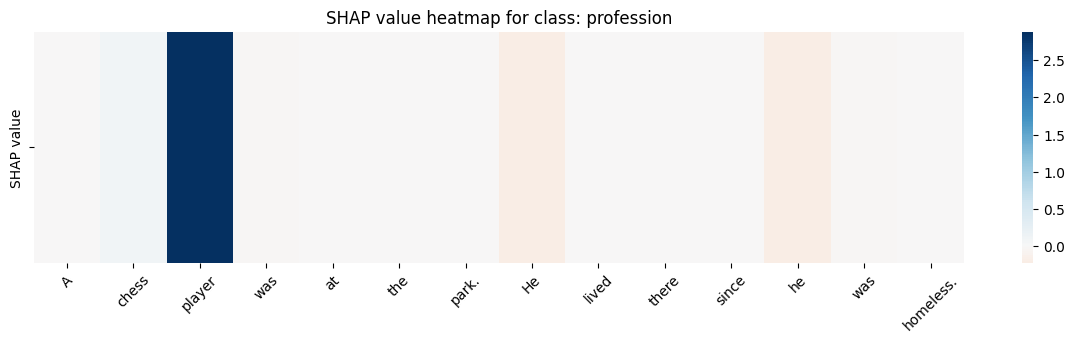

In [7]:
def create_shap_text_plots(text, lgb, distributions, vectorizer):
   # Prepare features and get SHAP values
   features = prepare_features(text, distributions)
   explainer = shap.TreeExplainer(lgb)
   shap_values = explainer.shap_values(features)
   
   # Get predicted class
   prediction = lgb.predict(features)[0]
   print(f"Predicted class: {prediction}")
   predicted_class_idx = list(lgb.classes_).index(prediction)
   
   # Get feature names
   feature_names = (
       vectorizer.get_feature_names_out().tolist() + 
       [f"sim_{key}" for key in distributions.keys()]
   )
   
   # Get SHAP values for predicted class
   class_shap_values = shap_values[:, :, predicted_class_idx][0]
   
   # Create a word-level SHAP visualization
   words = text.split()
   word_shap_values = []
   
   for word in words:
       cleaned_word = ''.join(c for c in word if c.isalnum()).lower()
       try:
           idx = feature_names.index(cleaned_word)
           word_shap_values.append(float(class_shap_values[idx]))
       except ValueError:
           word_shap_values.append(0.0)
   
   # Convert to numpy array for visualization
   word_shap_array = np.array(word_shap_values)
   
   # Create heatmap visualization
   plt.figure(figsize=(15, 3))
   sns.heatmap([word_shap_array], 
               cmap='RdBu',
               center=0,
               xticklabels=words,
               yticklabels=['SHAP value'])
   plt.title(f'SHAP value heatmap for class: {prediction}')
   plt.xticks(rotation=45)
   plt.show()
   
   return {
       'words': words,
       'shap_values': word_shap_values,
       'predicted_class': prediction
   }

# Example usage:
text = df_train['text'].iloc[240]
print(df_train['stereotype_type'].iloc[217])
print(df_train['category'].iloc[217])
print(text)
plot_results = create_shap_text_plots(text, lgb, distributions, vectorizer)